In [1]:
from collections import OrderedDict
import pandas as pd
import logging
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
from models import networks
from utils.dataset import FacesMemorabilityDataset, load_data
from utils.args import get_args
from utils.loss import *
from torch.utils.data import DataLoader
from torchvision import transforms
from pathlib import Path
import numpy as np
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import captum
from captum.attr import DeepLift, IntegratedGradients, Saliency, NoiseTunnel, GradientShap, GuidedGradCam
from captum.attr import visualization as viz
import argparse
import matplotlib
from torch.distributions import normal
from PIL import Image

/home/bhui/miniconda3/envs/xy_py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
args = get_args()
device = 'cuda:1'
args.target = 'happy'
dir_checkpoint = Path(f'./saved_weights/{args.model}/{args.target}')
dir_checkpoint.mkdir(parents=True, exist_ok=True)
random_seed = 42

In [3]:
labels_file = '../data/Wilma Bainbridge_10k US Adult Faces Database/Full Attribute Scores/final.xlsx' 
root_dir = '../data/Wilma Bainbridge_10k US Adult Faces Database/10k US Adult Faces Database/Face Images' 

In [4]:
train_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
train_df, val_df, test_df = load_data(labels_file, random_state=random_seed)
train_dataset = FacesMemorabilityDataset(dataframe=train_df, root_dir=root_dir, target=args.target, transform=train_transform)
val_dataset = FacesMemorabilityDataset(dataframe=val_df, root_dir=root_dir, target=args.target, transform=transform)
test_dataset = FacesMemorabilityDataset(dataframe=test_df, root_dir=root_dir, target=args.target, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

In [5]:
model = networks.VGG16()
model = model.to(device)
pretrain_weight = 'saved_weights' + '/' + args.model + '/' + args.target + '/' + 'best_model_0.86.pth'
print(f"load a pretrained model in {pretrain_weight}.")
checkpoint = torch.load(pretrain_weight)
model.load_state_dict(checkpoint)

load a pretrained model in saved_weights/VGG16/happy/best_model_0.86.pth.


<All keys matched successfully>

In [81]:
dataiter = iter(test_loader)
n = 2
for i in range(n):
    images, labels = next(dataiter)

images, labels = images.to(device), labels.to(device)

In [7]:
# ig = IntegratedGradients(model)
# dl = DeepLift(model)
def add_gaussian_noise(noise_scale, input):
    noise = torch.randn_like(input) * noise_scale
    return input + noise
    
def explanation(num_repeat, noise_scale, num_escape, sigma, ind, n_samples, stdevs):
    model.eval()
    input = images[ind].unsqueeze(0)
    input.requires_grad = True 
    image_batch = input.repeat(num_repeat, 1, 1, 1)
    noisy_images = add_gaussian_noise(noise_scale, image_batch)
    avg_noisy_image = noisy_images.mean(0, keepdim=True)
    
    baselines = avg_noisy_image * 0

    shap = GradientShap(model)
    attr_gradient = shap.attribute(avg_noisy_image, baselines=baselines, n_samples=50, stdevs=0.01)
    attr_gradient = ig.attribute(input, baselines=baselines, n_steps=1000)
    attr_gradient = dl.attribute(input, baselines=baselines)
    grad = attr_gradient.reshape(attr_gradient.shape[0], -1)
    w0 = grad.mean(dim=0)
    des, _ = torch.sort(grad, dim=0, descending=True)
    e11 = des[num_escape:]
    e1 = e11.mean(dim=0)
    e21 = des[:-num_escape]
    e2 = e21.mean(dim=0)
    e = torch.stack((e1, e2), dim=0)
    e = torch.abs(torch.sub(w0, e))
    e, _ = torch.max(e, dim=0)
    milestone = sigma * sigma / 2
    m = normal.Normal(0, sigma * sigma)
    g_x = torch.zeros(w0.shape[0], 3).to(device)
    g_x[:, 0] = 1 - m.cdf(torch.sub(milestone, w0))
    g_x[:, 1] = m.cdf(torch.sub(milestone, w0)) - m.cdf(torch.sub(-milestone, w0))
    g_x[:, 2] = m.cdf(torch.sub(-milestone, w0))
    g_x_p, _ = torch.sort(g_x, dim=1, descending=True)
    g_x_p = g_x_p[:, :2]
    radius = (sigma / 2 * (m.icdf(g_x_p[:, 0]) - m.icdf(g_x_p[:, 1])))
    failed = torch.gt(e, radius)
    g_x[failed == True, 0] = 0.0
    g_x[failed == True, 1] = 1.0
    g_x[failed == True, 2] = 0.0
    v_x = torch.argmax(g_x, dim=1)
    v_x = F.one_hot(v_x, num_classes=3)
    v_x = v_x.float()
    v_x[:, 0] = torch.mul(v_x[:, 0], 1.0)
    v_x[:, 1] = torch.mul(v_x[:, 1], -1.0)
    v_x[:, 2] = torch.mul(v_x[:, 2], -1.0)
    v_x = torch.sum(v_x, dim=1).float()
    v_x = v_x.reshape(grad.shape).to(device)
    grad = v_x
    grad = grad.reshape(1, 3, 224, 224)
    attr_visual = grad.squeeze().detach().cpu().numpy().transpose((1, 2, 0))
    attr_visual = (attr_visual - np.min(attr_visual)) / (np.max(attr_visual) - np.min(attr_visual))
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)

    input_visual = input.squeeze().cpu().detach().numpy().transpose((1, 2, 0))
    
    plt.imshow(input_visual)
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(attr_visual, cmap='hot')
    plt.title("Attribution Map By VGG16")
    plt.axis('off')
    
    # plt.subplot(1, 3, 3)
    # plt.imshow(brightened_attr, cmap='hot')
    # plt.title("Brightened Attribution Map By VGG16")
    # plt.axis('off')
    plt.show()

In [96]:
model.eval()
ind = 4
input = images[ind].unsqueeze(0)
input.requires_grad = True 
baselines = input * 0
input_visual = input.squeeze().cpu().detach().numpy().transpose((1, 2, 0))

In [97]:
print(model(input))
print(labels[ind])

tensor([[6.1874]], device='cuda:1', grad_fn=<AddmmBackward0>)
tensor(6.8667, device='cuda:1', dtype=torch.float64)


In [98]:
cam = GuidedGradCam(model, layer=model.vgg16.features[30])
attr_gradient = cam.attribute(input)
attr_visual = attr_gradient.squeeze().detach().cpu().numpy().transpose((1, 2, 0))
# attr_visual = (attr_visual - np.min(attr_visual)) / (np.max(attr_visual) - np.min(attr_visual))

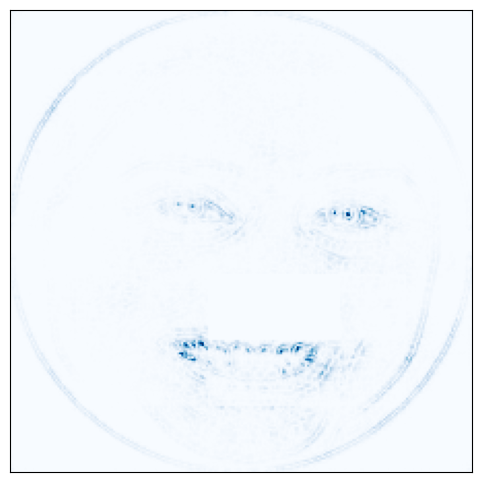

(<Figure size 600x600 with 1 Axes>, <AxesSubplot:>)

In [99]:
viz.visualize_image_attr(attr=attr_visual, original_image=input_visual, method="heat_map")

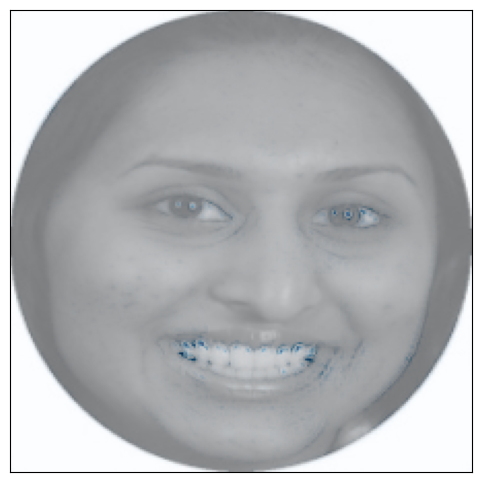

(<Figure size 600x600 with 1 Axes>, <AxesSubplot:>)

In [100]:
viz.visualize_image_attr(attr=attr_visual, original_image=input_visual, method="blended_heat_map")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


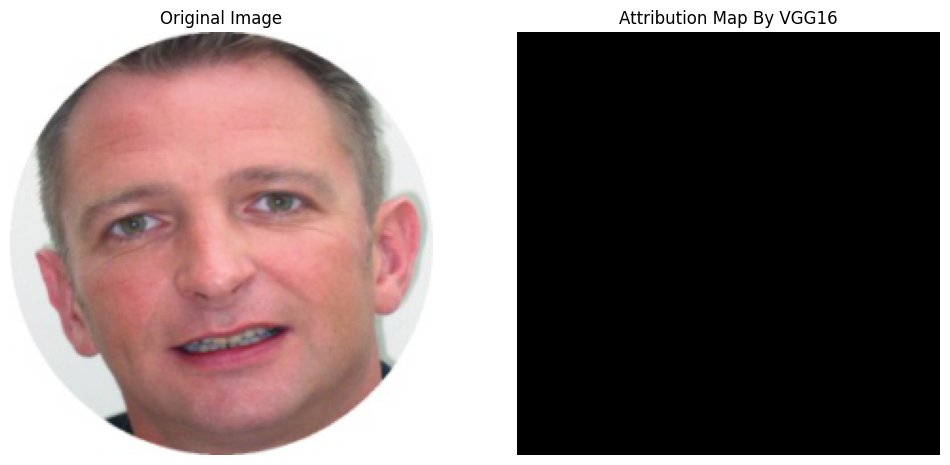

In [14]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(input_visual)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(attr_visual, cmap='hot')
plt.title("Attribution Map By VGG16")
plt.axis('off')

plt.show()

In [ ]:
explanation(num_repeat=100, noise_scale=0.25, num_escape=1000, sigma=0.25, ind=15, n_samples=1, stdevs=0.1)

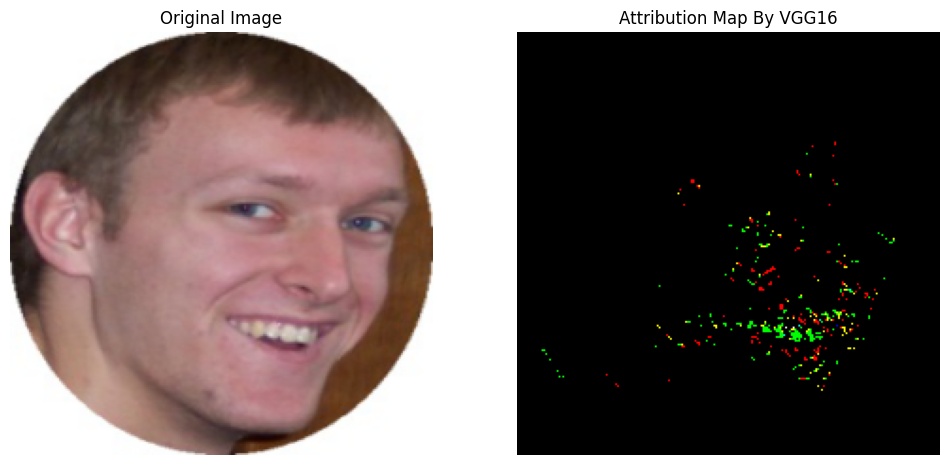

In [37]:
explanation(num_repeat=100, noise_scale=0.25, num_escape=1000, sigma=0.25, ind=14, n_samples=1, stdevs=0.1)

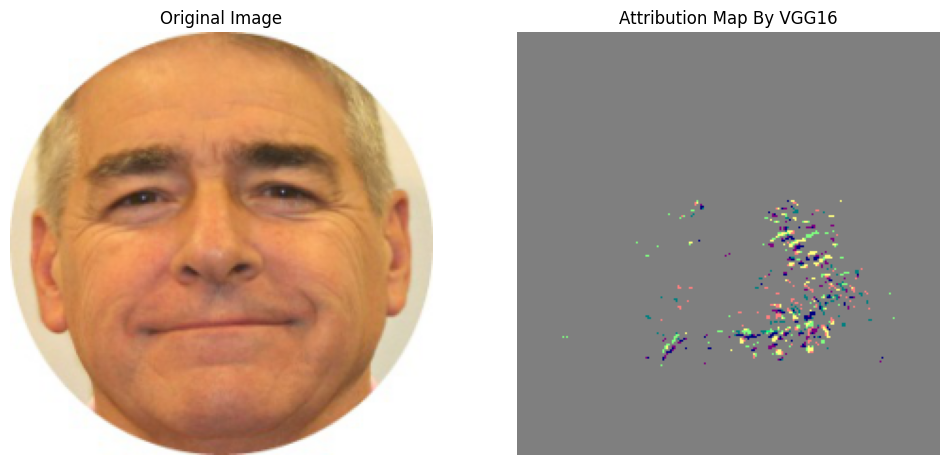

In [25]:
explanation(1000, 0.25, 1, input*0, 50, 0.1)

In [50]:
image_path = 'xy.jpg'
image = Image.open(image_path).convert('RGB') 
input_tensor = transform(image)
input_tensor = input_tensor.unsqueeze(0)
input_tensor = input_tensor.to(device)
input_tensor.requires_grad = True

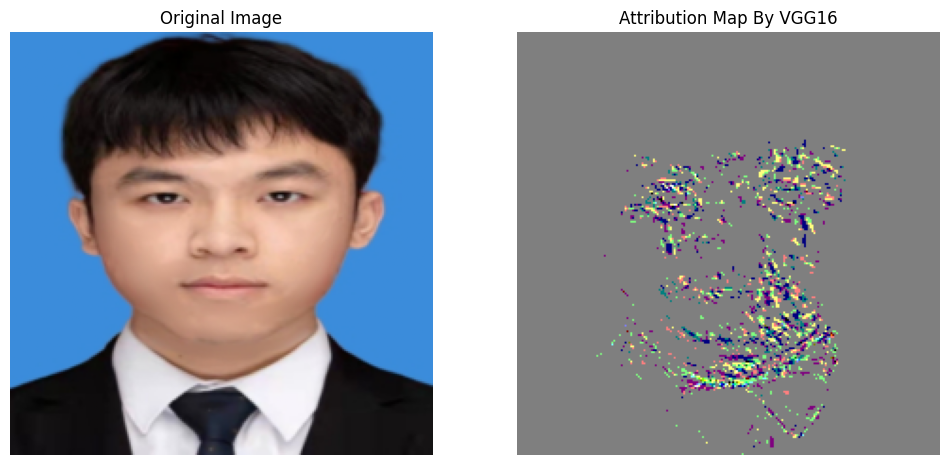

In [53]:
explanation(1000, 0.25, input_tensor, input_tensor*0, 50, 0.5)

In [18]:
model.eval()
attr_gradient = shap.attribute(input_tensor, baselines=input_tensor*0, n_samples=50, stdevs=0.01)
attr_visual = attr_gradient.squeeze().detach().cpu().numpy().transpose((1, 2, 0))
attr_visual = (attr_visual - np.min(attr_visual)) / (np.max(attr_visual) - np.min(attr_visual))

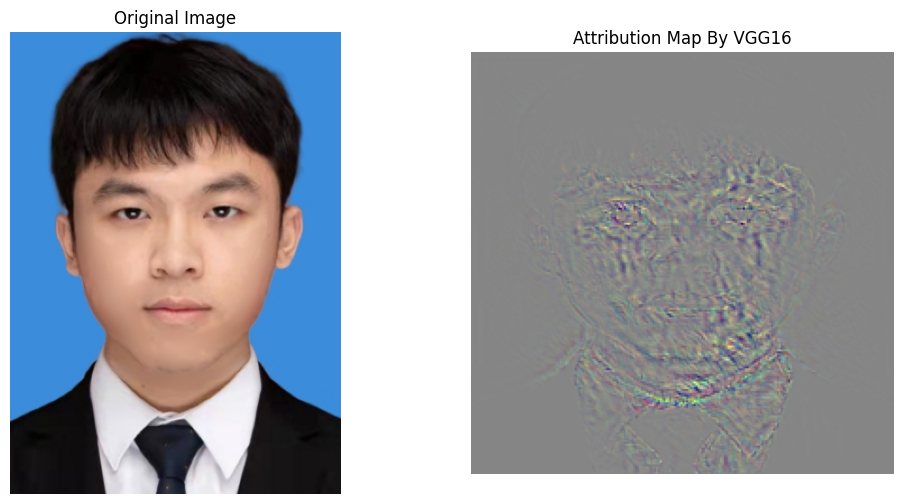

In [19]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(attr_visual, cmap='magma')
plt.title("Attribution Map By VGG16")
plt.axis('off')
plt.show()

In [20]:
output_tensor = model(input_tensor)

In [21]:
output_tensor

tensor([[4.6381]], device='cuda:1', grad_fn=<AddmmBackward0>)

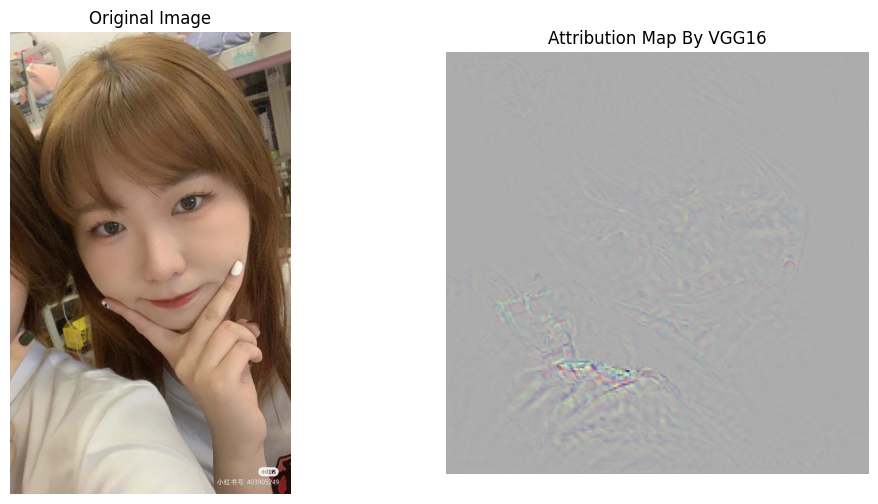

tensor([[5.0605]], device='cuda:1', grad_fn=<AddmmBackward0>)


In [22]:
image_path = 'dyq.jpg'
image = Image.open(image_path).convert('RGB') 
input_tensor = transform(image)
input_tensor = input_tensor.unsqueeze(0)
input_tensor = input_tensor.to(device)
input_tensor.requires_grad = True
model.eval()
attr_gradient = shap.attribute(input_tensor, baselines=input_tensor*0, n_samples=50, stdevs=0.01)
attr_visual = attr_gradient.squeeze().detach().cpu().numpy().transpose((1, 2, 0))
attr_visual = (attr_visual - np.min(attr_visual)) / (np.max(attr_visual) - np.min(attr_visual))
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(attr_visual, cmap='magma')
plt.title("Attribution Map By VGG16")
plt.axis('off')
plt.show()

output_tensor = model(input_tensor)
print(output_tensor)

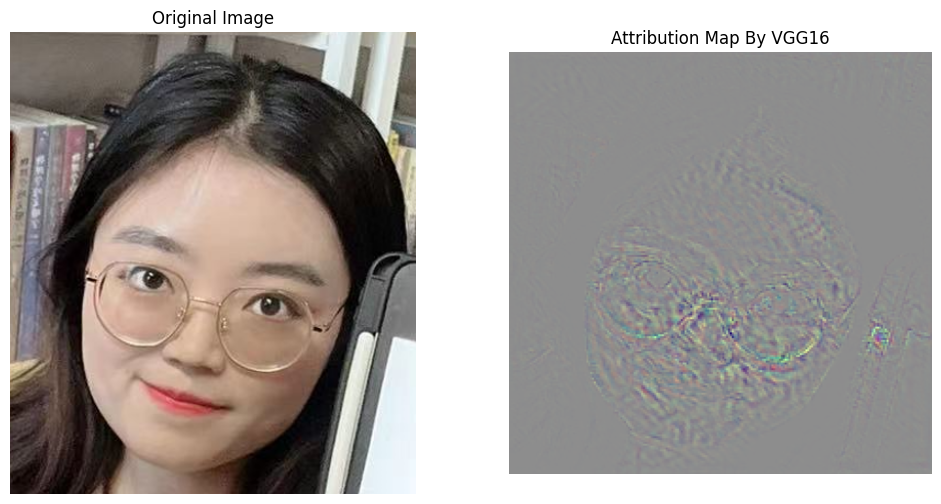

tensor([[5.2944]], device='cuda:1', grad_fn=<AddmmBackward0>)


In [23]:
image_path = 'hhl.png'
image = Image.open(image_path).convert('RGB') 
input_tensor = transform(image)
input_tensor = input_tensor.unsqueeze(0)
input_tensor = input_tensor.to(device)
input_tensor.requires_grad = True
model.eval()
attr_gradient = shap.attribute(input_tensor, baselines=input_tensor*0, n_samples=50, stdevs=0.01)
attr_visual = attr_gradient.squeeze().detach().cpu().numpy().transpose((1, 2, 0))
attr_visual = (attr_visual - np.min(attr_visual)) / (np.max(attr_visual) - np.min(attr_visual))
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(attr_visual, cmap='magma')
plt.title("Attribution Map By VGG16")
plt.axis('off')
plt.show()

output_tensor = model(input_tensor)
print(output_tensor)

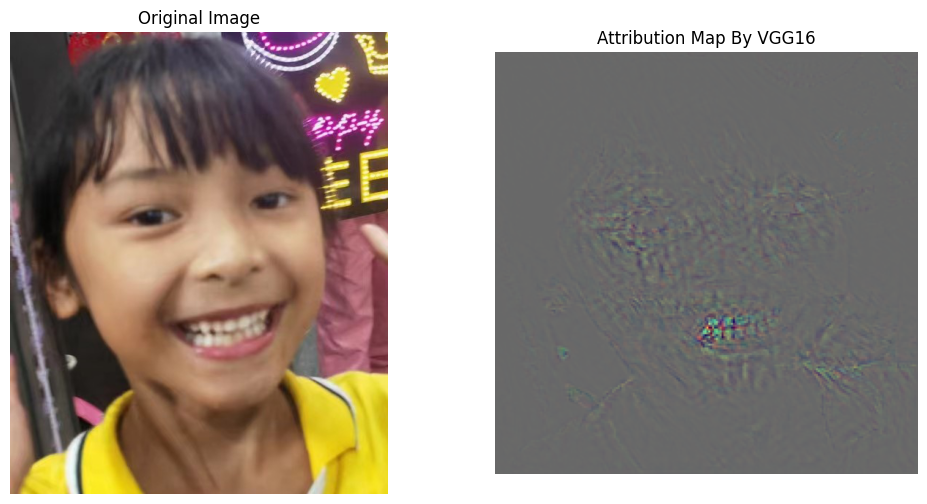

tensor([[5.7778]], device='cuda:1', grad_fn=<AddmmBackward0>)


In [24]:
image_path = 'xyy.jpg'
image = Image.open(image_path).convert('RGB') 
input_tensor = transform(image)
input_tensor = input_tensor.unsqueeze(0)
input_tensor = input_tensor.to(device)
input_tensor.requires_grad = True
model.eval()
attr_gradient = shap.attribute(input_tensor, baselines=input_tensor*0, n_samples=50, stdevs=0.01)
attr_visual = attr_gradient.squeeze().detach().cpu().numpy().transpose((1, 2, 0))
attr_visual = (attr_visual - np.min(attr_visual)) / (np.max(attr_visual) - np.min(attr_visual))
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(attr_visual, cmap='magma')
plt.title("Attribution Map By VGG16")
plt.axis('off')
plt.show()

output_tensor = model(input_tensor)
print(output_tensor)

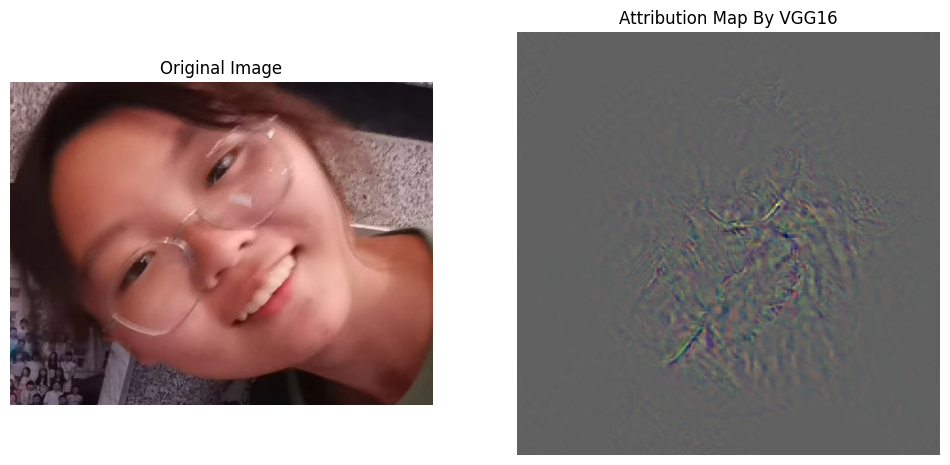

tensor([[4.3123]], device='cuda:1', grad_fn=<AddmmBackward0>)


In [25]:
image_path = 'banjiu.jpg'
image = Image.open(image_path).convert('RGB') 
input_tensor = transform(image)
input_tensor = input_tensor.unsqueeze(0)
input_tensor = input_tensor.to(device)
input_tensor.requires_grad = True
model.eval()
attr_gradient = shap.attribute(input_tensor, baselines=input_tensor*0, n_samples=50, stdevs=0.01)
attr_visual = attr_gradient.squeeze().detach().cpu().numpy().transpose((1, 2, 0))
attr_visual = (attr_visual - np.min(attr_visual)) / (np.max(attr_visual) - np.min(attr_visual))
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(attr_visual, cmap='magma')
plt.title("Attribution Map By VGG16")
plt.axis('off')
plt.show()

output_tensor = model(input_tensor)
print(output_tensor)